In [2]:
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize'] = [15, 15]

module_y = 56.50
module_x = 43.10+0.5
# 42.5 x 22
sensor_y = 22 # 0.5 split in between the two sensors
sensor_x = 42.50
sensor_gap = 0.5
mount_y = (module_y-2*sensor_y-sensor_gap)/2.

disk_inner = 315
disk_outer = 1185 #1185

PB_y = 29.5
PB_x = module_x

patchpanel_length = 300 # was 50

#services_x = 50

In [3]:
def getEta(radius):
    return -math.log(math.tan(math.atan(radius/3000.)/2))

In [145]:
def getMinRadius(points):
    # the innermost point
    r_min = 99999
    for x,y in points:
        if math.sqrt(x**2+y**2)<r_min: r_min = math.sqrt(x**2+y**2)
    return r_min

In [146]:
def getRBs(length, y, radius=0):
    tmp = length
    nSeven = 0
    nSix = 0
    nThree = 0
    #if length>7 and radius<470 and abs(y)<400 and abs(y)>300: nThree = 2
    if length>7 and radius<470:
        if abs(y)<470 and abs(y)>300:
            nThree = 2
        else:
            nThree = 1
    #if length>7 and radius<470: nThree = 1
    length = length - nThree*3 # new
    nSevenMax = int(length/7)
    for i in reversed(range(nSevenMax+1)):
        if (length-i*7)%3==0 and (length-i*7>=0 or length==7):
        #if (length-i*7)%3==0 and (((length-i*7)>0) or length==7):
            length = length-i*7
            nSeven = i
            break
    #print (nSeven)
    #nSix = int((length-nThree*3)/6)
    nSix = int(length/6) # new
    #if (length-nThree*3)%6>0:
    if length%6>0:
        nThree += 1
    #print (nThree, nSix, nSeven)
    if length == 11: 
        nSeven+=1
        nSix-=1 # that's after subtraction
    column = [3]*nThree + [6]*nSix + [7]*nSeven
    if not sum(column) == tmp: print ("Something went wrong")
    return column

In [147]:
 def makeModule(xmin, ymin, honesty="idk"):
    outline = [
        [xmin, ymin],
        [xmin, ymin+module_y],
        [xmin+module_x, ymin+module_y],
        [xmin+module_x, ymin]
    ]
    
    activeAreaLower = [
        [xmin+(module_x-sensor_x)/2., ymin+mount_y-sensor_gap/2.],
        [xmin+(module_x-sensor_x)/2., ymin+mount_y+sensor_y-sensor_gap/2.],
        [xmin+sensor_x+(module_x-sensor_x)/2., ymin+mount_y+sensor_y-sensor_gap/2.],
        [xmin+sensor_x+(module_x-sensor_x)/2., ymin+mount_y-sensor_gap/2.]
    ]
    
    center_lower = (xmin+module_x/2., ymin+mount_y+sensor_y/2.)
    
    activeAreaUpper = [
        [xmin+(module_x-sensor_x)/2., ymin+mount_y+sensor_y+sensor_gap],
        [xmin+(module_x-sensor_x)/2., ymin+mount_y+2*sensor_y+sensor_gap],
        [xmin+sensor_x+(module_x-sensor_x)/2., ymin+mount_y+2*sensor_y+sensor_gap],
        [xmin+sensor_x+(module_x-sensor_x)/2., ymin+mount_y+sensor_y+sensor_gap]
    ]
    
    center_upper = (xmin+module_x/2., ymin+mount_y+sensor_gap+sensor_y+sensor_y/2.)

    r_min = getMinRadius(activeAreaLower)
    # check if they are all inside the circle
    for x,y in outline:
        if math.sqrt(x**2+y**2)>disk_outer:
            return False, False
        if math.sqrt(x**2+y**2)<disk_inner:
            return False, False
        if (ymin+module_y)**2 > disk_outer**2:
            return False, False
        y_measure = ymin+module_y if ymin>0 else ymin
        if x > ( math.sqrt(disk_outer**2 - (y_measure)**2) - patchpanel_length ) and honesty=='superHigh':
            return False, False
    return [plt.Polygon(outline, closed=True, fill=None, edgecolor='b'), plt.Polygon(activeAreaLower, closed=True, fc=(1,0,0,0.5), ec=(0,0,0,1)), plt.Polygon(activeAreaUpper, closed=True, fc=(1,0,0,0.5), ec=(0,0,0,1))], [r_min, center_lower, center_upper]

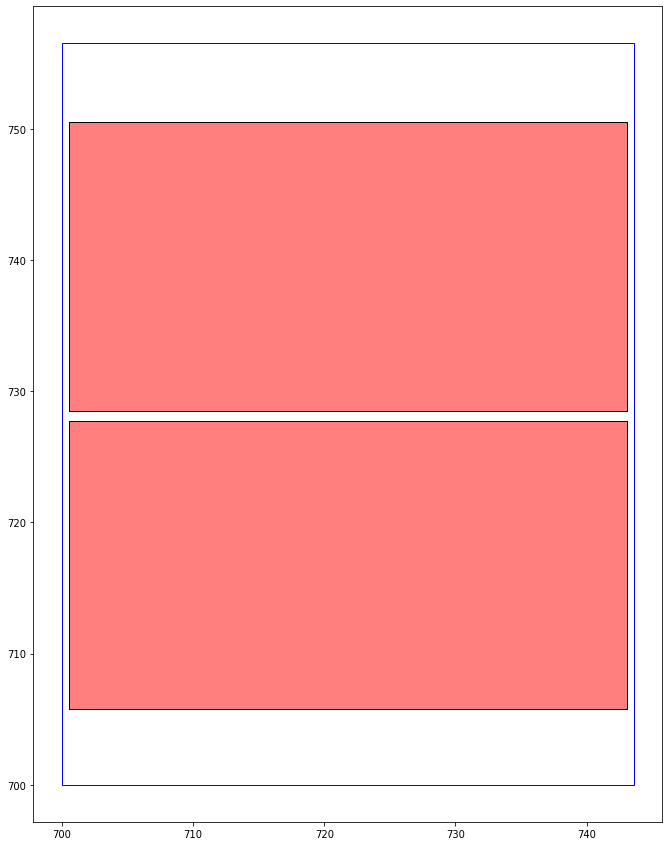

In [148]:
modules = makeModule(700, 700, honesty='Low')
for m in modules[0]:
    plt.gca().add_patch(m)
plt.axis('scaled')
plt.show()

In [149]:
def makeReadOutBoard(xmin, ymin, length):
    outline = [[xmin, ymin], [xmin, ymin+module_y], [xmin+module_x*length, ymin+module_y], [xmin+module_x*length, ymin]]
    # check if they are all inside the circle
    for x,y in outline:
        if math.sqrt(x**2+y**2)>disk_outer:
            return False
        if math.sqrt(x**2+y**2)<disk_inner:
            return False
    if length==3:
        color = (0,1,1,0.9)
    if length==6:
        color = (1,0,1,0.9)
    if length==7:
        color = (1,1,0,0.9)
    return [plt.Polygon(outline, closed=True, fc=color, ec=(0,0,0,1))]

In [150]:
def makePowerBoard(xmin, ymin):
    outline = [[xmin, ymin], [xmin, ymin+PB_y], [xmin+PB_x, ymin+PB_y], [xmin+PB_x, ymin]]
    # check if they are all inside the circle
    for x,y in outline:
        if math.sqrt(x**2+y**2)>disk_outer:
            return False
        if math.sqrt(x**2+y**2)<disk_inner:
            return False
    return [plt.Polygon(outline, closed=True, fc=(0,1,0,0.5), ec=(0,0,0,1))]

In [151]:
def fillDee(xmin, ymin, xmax=disk_outer, ymax=disk_outer, ymin_RB=False, showRB=True, showPB=True, honesty="Low", PB='left', onlyActive=False):
    min_r, max_r = 99999, 0
    if not ymin_RB: ymin_RB=ymin
    nRB = 0
    nModules = 0
    nRB_three = 0
    nRB_six = 0
    nRB_seven = 0
    modules = []
    r_mins = []
    sensor_centers = []
    row_lengths = []
    y = ymin
    while y<ymax:
        # one row at a time
        row_length = 0
        r_min = 9999
        x=xmin
        while x<xmax:
            tmp, r = makeModule(x, y, honesty=honesty)
            if onlyActive and tmp: tmp = tmp[1:3]
            if tmp:
                if PB=='left':
                    tmp2 = makePowerBoard(x, y-PB_y)
                elif PB=='right':
                    tmp2 = makePowerBoard(x, y+module_y)
                if honesty=='Low':
                    modules += tmp
                    sensor_centers += r[1:3]
                    row_length += 1
                elif honesty.count('High') and tmp2:
                    modules += tmp
                    sensor_centers += r[1:3]
                    row_length += 1
                if tmp2 and showPB:
                    modules += tmp2
                    nModules += 1
                #row_length += 1
            x += module_x
            if r:
                if r[0] < r_min and r[0]>0 and y>0: r_min = r[0]
        
        r_mins.append(r_min)
        itemsToRemove = 4 if showPB else 3
        if onlyActive: itemsToRemove -= 1
        if row_length == 8:
            modules = modules[:-itemsToRemove] # remove last items
            sensor_centers = sensor_centers[:-2]
            row_length = 7
            nModules -= 1
        if row_length == 4:
            modules = modules[:-itemsToRemove] # remove last items
            sensor_centers = sensor_centers[:-2]
            row_length = 3
            nModules -= 1
        if row_length == 11:
            modules = modules[:-itemsToRemove] # remove last items
            sensor_centers = sensor_centers[:-2]
            row_length = 10
            nModules -= 1
        if row_length == 5:
            modules = modules[:-itemsToRemove] # remove last items
            sensor_centers = sensor_centers[:-2]
            modules = modules[:-itemsToRemove] # remove last items
            sensor_centers = sensor_centers[:-2]
            row_length = 3
            nModules -= 2
        row_lengths.append(row_length)
        #print (row_length)
        # put the readout boards
        if row_length>2 and y>ymin_RB and showRB:
            #print(row_length)
            board_lengths = getRBs(row_length, y, abs(y))
            #print(board_lengths)
            iBoard = 0
            x=xmin
            while x<xmax:
                tmp = makeReadOutBoard(x, y,board_lengths[iBoard])
                if tmp:
                    if PB=='left':
                        tmp2 = makePowerBoard(x, y-PB_y)
                    elif PB=='right':
                        tmp2 = makePowerBoard(x, y+module_y)
                    if honesty=='Low':
                        modules += tmp
                        x += module_x*board_lengths[iBoard]
                        nRB += 1
                        nRB_three += 1 if board_lengths[iBoard]==3 else 0
                        nRB_six += 1 if board_lengths[iBoard]==6 else 0
                        nRB_seven += 1 if board_lengths[iBoard]==7 else 0
                        iBoard += 1
                    elif honesty.count('High') and tmp2:
                        modules += tmp
                        x += module_x*board_lengths[iBoard]
                        nRB += 1
                        nRB_three += 1 if board_lengths[iBoard]==3 else 0
                        nRB_six += 1 if board_lengths[iBoard]==6 else 0
                        nRB_seven += 1 if board_lengths[iBoard]==7 else 0
                        iBoard += 1
                    else:
                        x += module_x
                else:
                    x += module_x
                if iBoard >= len(board_lengths): break
                #y += module_y*board_lengths[iBoard]
        
        
        y += (module_y+PB_y)
    #print (row_lengths)
    print ("Number of RBs:", nRB, nRB*8)
    print ("Number of len3 RBs:", nRB_three, nRB_three*8)
    print ("Number of len6 RBs:", nRB_six, nRB_six*8)
    print ("Number of len7 RBs:", nRB_seven, nRB_seven*8)
    print ("Number of Modules:", nModules, nModules*8)
    return modules, r_mins, sensor_centers

In [152]:
def putServices():
    #outline = [[xmin, ymin], [xmin, ymin+PB_y], [xmin+PB_x, ymin+PB_y], [xmin+PB_x, ymin]]
    #outline = [[math.sqrt(disk_outer**2-(module_y*(2x+1)/2+x*PB_y)**2), module_y*(2x+1)+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2x+1)/2+x*PB_y)**2)-50,module_y*(2x+1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2x+1)/2+x*PB_y)**2)-50,module_y*(2x-1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2x+1)/2+x*PB_y)**2),module_y*(2x-1)/2+x*PB_y]]
    services = []
    # check if they are all inside the circle
    for x in range(-13,14):
        if x>1:
            outline = [[math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2), module_y*(2*x+1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2)-50,module_y*(2*x+1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2)-50, module_y*(2*x-1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2),module_y*(2*x-1)/2+x*PB_y]]
        else:
            outline = [[math.sqrt(disk_outer**2-(module_y*(2*x-1)/2+x*PB_y)**2), module_y*(2*x-1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x-1)/2+x*PB_y)**2)-50,module_y*(2*x-1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x-1)/2+x*PB_y)**2)-50, module_y*(2*x+1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x-1)/2+x*PB_y)**2),module_y*(2*x+1)/2+x*PB_y]]
            #outline = [[math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2), module_y*(2*x+1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2)-50,module_y*(2*x+1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2)-50, module_y*(2*x-1)/2+x*PB_y], [math.sqrt(disk_outer**2-(module_y*(2*x+1)/2+x*PB_y)**2),module_y*(2*x-1)/2+x*PB_y]]
        services += [plt.Polygon(outline, closed=True, fc=(0.7,0.3,0.5,0.5), ec=(0,0,0,1))]
        #if math.sqrt(x**2+y**2)>disk_outer:
        #    return False
        #if math.sqrt(x**2+y**2)<disk_inner:
        #    return False
    return services

Something went wrong
Something went wrong
Number of RBs: 65 520
Number of len3 RBs: 31 248
Number of len6 RBs: 16 128
Number of len7 RBs: 18 144
Number of Modules: 315 2520


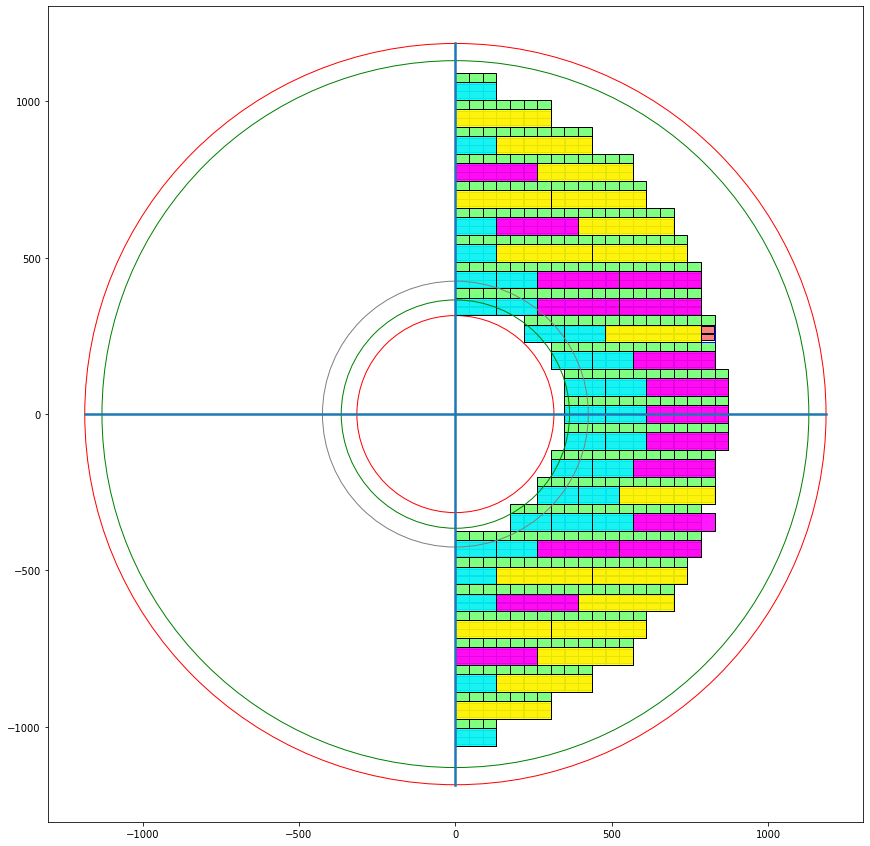

In [153]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

modules = []

#modules += fillDeeWithModules(-28.25,-1163.7)[0]

#modules += fillDee(-28.25-((56.5+29.5)*15),0, showRB=True, showPB=True, honesty='High')[0]
modules += fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, showRB=True, showPB=True, honesty='superHigh', PB='right')[0]

#modules += fillDeeWithPBs(28.25-(56.5+29.5)*15,0,xmax=disk_outer-PB_x*2)

#modules += fillDeeWithModules(-56.5-14.75-((56.5+29.5)*15),0)[0]
#modules += fillDeeWithPBs(56.5+14.75-(56.5+29.5)*15,0,xmax=disk_outer-PB_x*4)

#modules += fillDeeWithModules(-56.5-14.75-((56.5+29.5)*15),-1163.7,ymax=0)[0]
#modules += fillDeeWithPBs(56.5+14.75-(56.5+29.5)*15,-1163.7,ymax=0, xmax=0)
#modules = fillQuadrantWithModules(-28.25-((56.5+29.5)*15),-1163.7)
#modules = fillQuadrantWithModules(-56.5-((56.5+29.5)*15),-1163.7)

#modules += fillDeeWithModules(-28.25-((56.5+29.5)*15),-1163.7)[0]
#modules += fillDeeWithModules(-56.5-14.75-((56.5+29.5)*15),-1163.7)[0]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)
for m in modules:
    plt.gca().add_patch(m)

hori = plt.Line2D((-1185, 1185), (0, 0), lw=2.5)
vert = plt.Line2D((0, 0), (-1185, 1185), lw=2.5)

plt.gca().add_line(hori)
plt.gca().add_line(vert)

coverage_inner = plt.Circle((0, 0), 365,fill=None, edgecolor='green')
coverage_outer = plt.Circle((0, 0), 1130,fill=None, edgecolor='green')
plt.gca().add_patch(coverage_inner)
plt.gca().add_patch(coverage_outer)

highflux = plt.Circle((0, 0), 425,fill=None, edgecolor='gray')
plt.gca().add_patch(highflux)

#testPCB = [[math.sqrt(disk_outer**2-(module_y*(-3.)/2-1*PB_y)**2), module_y*(-3.)/2-1*PB_y], [math.sqrt(disk_outer**2-(module_y*5./2+2*PB_y)**2)-50,module_y*5./2+2*PB_y], [math.sqrt(disk_outer**2-(module_y*5./2+2*PB_y)**2)-50,module_y*3./2+2*PB_y], [math.sqrt(disk_outer**2-(module_y*5./2+2*PB_y)**2),module_y*3./2+2*PB_y]]
#plt.gca().add_patch(plt.Polygon(testPCB, closed=True, fc=(0.7,0.3,0.5,0.9), ec=(0,0,0,1)))
services = []
#services += putServices()
for s in services:
    plt.gca().add_patch(s)

plt.axis('scaled')
plt.show()

Something went wrong
Something went wrong
Number of RBs: 68 544
Number of len3 RBs: 32 256
Number of len6 RBs: 25 200
Number of len7 RBs: 11 88
Number of Modules: 323 2584


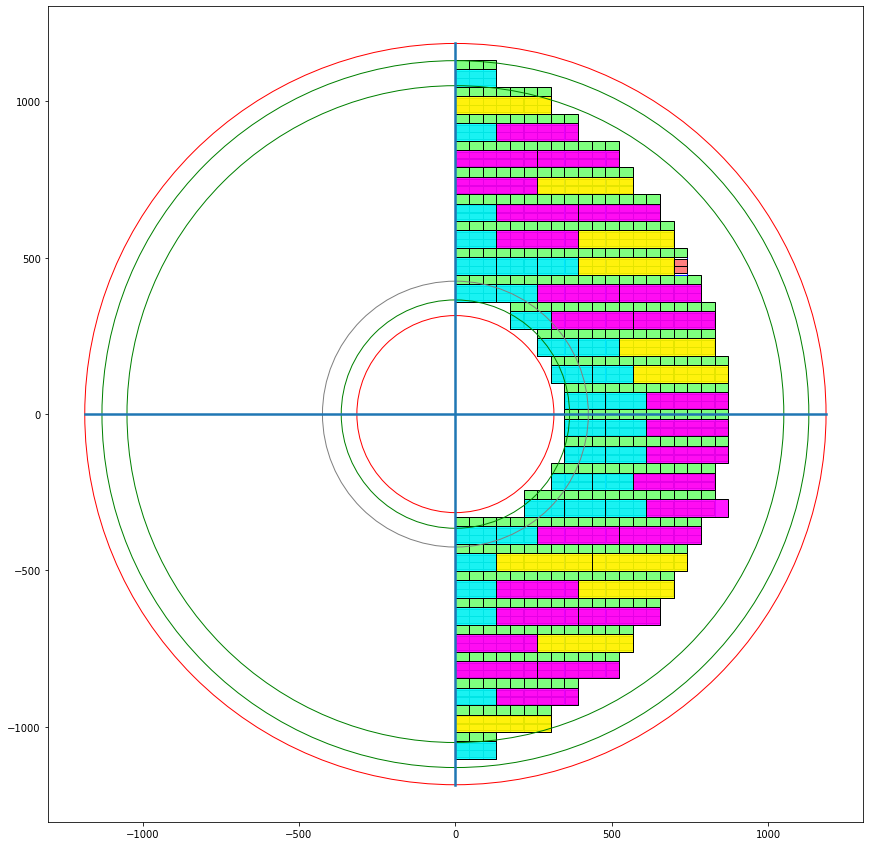

In [154]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

modules = []

modules += fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), showRB=True, showPB=True, honesty='superHigh', PB='right')[0]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)
for m in modules:
    plt.gca().add_patch(m)

hori = plt.Line2D((-1185, 1185), (0, 0), lw=2.5)
vert = plt.Line2D((0, 0), (-1185, 1185), lw=2.5)

plt.gca().add_line(hori)
plt.gca().add_line(vert)

coverage_inner = plt.Circle((0, 0), 365,fill=None, edgecolor='green')
coverage_outer = plt.Circle((0, 0), 1130,fill=None, edgecolor='green')
coverage_outer2 = plt.Circle((0, 0), 1050,fill=None, edgecolor='green')
plt.gca().add_patch(coverage_inner)
plt.gca().add_patch(coverage_outer)
plt.gca().add_patch(coverage_outer2)

highflux = plt.Circle((0, 0), 425,fill=None, edgecolor='gray')
plt.gca().add_patch(highflux)

plt.axis('scaled')
plt.show()

Number of RBs: 0 0
Number of len3 RBs: 0 0
Number of len6 RBs: 0 0
Number of len7 RBs: 0 0
Number of Modules: -8 -64
Number of RBs: 0 0
Number of len3 RBs: 0 0
Number of len6 RBs: 0 0
Number of len7 RBs: 0 0
Number of Modules: 0 0
Number of RBs: 0 0
Number of len3 RBs: 0 0
Number of len6 RBs: 0 0
Number of len7 RBs: 0 0
Number of Modules: -8 -64
Number of RBs: 0 0
Number of len3 RBs: 0 0
Number of len6 RBs: 0 0
Number of len7 RBs: 0 0
Number of Modules: 0 0


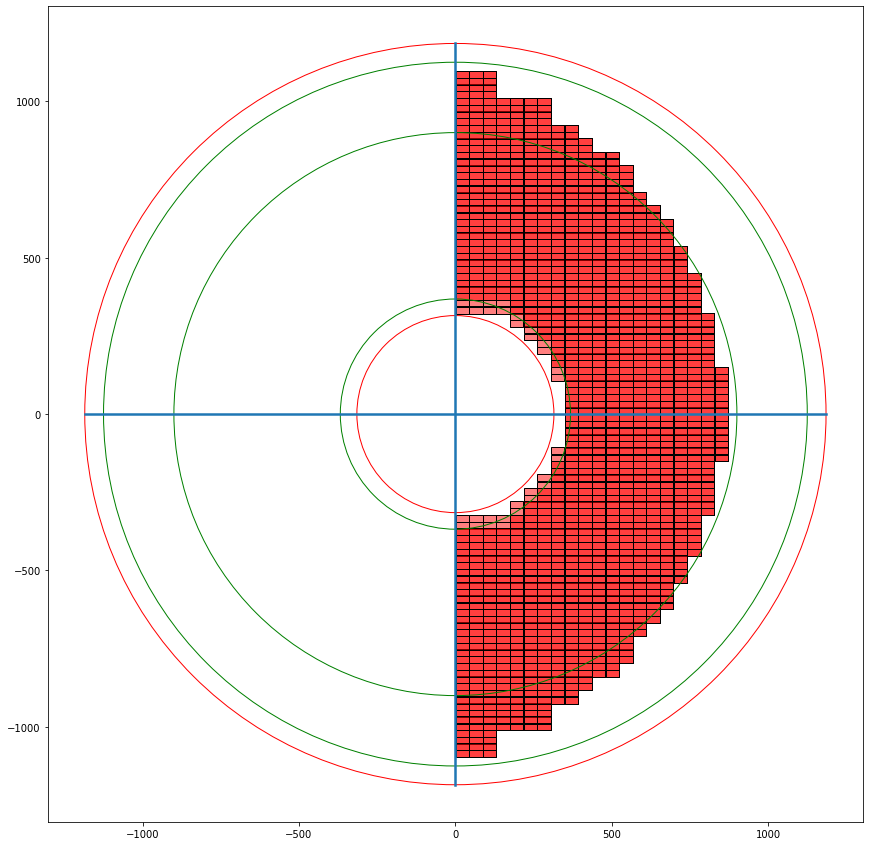

2.7951725370702523
1.7074114360431305
Number of modules 2552


In [164]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

modules = []

modules += fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='superHigh', PB='left', onlyActive=True)[0]
modules += fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='superHigh', PB='left', onlyActive=True)[0]

modules += fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='superHigh', PB='right', onlyActive=True)[0]
modules += fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), xmax=1185, ymax=1185, showRB=False, showPB=False, honesty='superHigh', PB='right', onlyActive=True)[0]



plt.gca().add_patch(inner)
plt.gca().add_patch(outer)
for m in modules:
    plt.gca().add_patch(m)

hori = plt.Line2D((-1185, 1185), (0, 0), lw=2.5)
vert = plt.Line2D((0, 0), (-1185, 1185), lw=2.5)

plt.gca().add_line(hori)
plt.gca().add_line(vert)

coverage_inner = plt.Circle((0, 0), 368,fill=None, edgecolor='green')
coverage_outer = plt.Circle((0, 0), 1125,fill=None, edgecolor='green')
coverage_outer2 = plt.Circle((0, 0), 900,fill=None, edgecolor='green')
plt.gca().add_patch(coverage_inner)
plt.gca().add_patch(coverage_outer)
plt.gca().add_patch(coverage_outer2)

plt.axis('scaled')
plt.show()

# realistic coverage, max eta
max_eta = getEta(368)
# realistic coverage, min eta
min_eta = getEta(1125)
print (max_eta)
print (min_eta)
print ("Number of modules", len(modules))

In [133]:
# ideal coverage, max eta
max_eta = getEta(315)
# ideal coverage, min eta
min_eta = getEta(1185)
print max_eta
print min_eta

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(max_eta)? (<ipython-input-133-58e33accfff1>, line 5)

In [134]:
getRBs(3,900)

[3]

In [165]:
getEta(900)

1.9188964720985309

In [156]:
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [157]:
with open('database.yaml') as f:
    database = load(f, Loader=Loader)

In [158]:
disk_setting = \
    {'300mm':
     {'disk1':
      {'front': fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, showRB=True, showPB=True, honesty='superHigh', PB='right')[2],
       'back': fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), xmax=1185, showRB=True, showPB=True, honesty='superHigh', PB='right')[2]
      },
      'disk2':
      {'front': fillDee(0,-module_y/2-((module_y+PB_y)*15), xmax=1185, showRB=True, showPB=True, honesty='superHigh', PB='left')[2],
      'back': fillDee(0,-module_y-PB_y/2-((module_y+PB_y)*15), xmax=1185, showRB=True, showPB=True, honesty='superHigh', PB='left')[2]
      }
     }
    }

Something went wrong
Something went wrong
Number of RBs: 65 520
Number of len3 RBs: 31 248
Number of len6 RBs: 16 128
Number of len7 RBs: 18 144
Number of Modules: 315 2520
Something went wrong
Something went wrong
Number of RBs: 68 544
Number of len3 RBs: 32 256
Number of len6 RBs: 25 200
Number of len7 RBs: 11 88
Number of Modules: 323 2584
Something went wrong
Something went wrong
Number of RBs: 65 520
Number of len3 RBs: 31 248
Number of len6 RBs: 16 128
Number of len7 RBs: 18 144
Number of Modules: 315 2520
Something went wrong
Something went wrong
Number of RBs: 68 544
Number of len3 RBs: 33 264
Number of len6 RBs: 23 184
Number of len7 RBs: 12 96
Number of Modules: 323 2584


In [159]:
database.update(disk_setting)

In [160]:
with open('database.yaml', 'w') as f:
    dump(database, f, Dumper=Dumper, default_flow_style=False)

In [161]:
database.keys()

dict_keys(['0mm', '150mm', '50mm', '65mm', '85mm', 'empty', '300mm'])

In [162]:
len(database['300mm']['disk1']['front'])

630

In [221]:
def getAllCenters(config):
    return database[config]['disk1']['front'] + database[config]['disk1']['back'] + database[config]['disk2']['front'] + database[config]['disk2']['back']

def getColumnCoordinates(allCenters):
    return set([ x for x,y in allCenters])

In [257]:
allCenters = getAllCenters('300mm')
column_coordinates = getColumnCoordinates(allCenters)
area = 0
for column_x in sorted(column_coordinates):
    column = [ y for x,y in allCenters if (x==column_x and y>0)]
    #print (column_x)
    #print (column)
    #print (max(column), min(column))
    #break
    area += 2*(max(column)-min(column)+sensor_y)*sensor_x # need to check this
print ("Geometrical coverage, disk: %.4f"%(area/((disk_outer**2-disk_inner**2)*math.pi/2))) # full disk
#print ("Geometrical coverage, eta range: %s"%(area/((1133**2-366**2)*math.pi/2))) # for eta 1.7-2.8

Geometrical coverage, disk: 0.5767


In [207]:
def getFractionOfLostModules(config):
    nModulesAll = len(database['0mm']['disk1']['front'] + database['0mm']['disk1']['back'] + database['0mm']['disk2']['front'] + database['0mm']['disk2']['back'])
    nModulesRed = len(database[config]['disk1']['front'] + database[config]['disk1']['back'] + database[config]['disk2']['front'] + database[config]['disk2']['back'])
    return nModulesRed/nModulesAll

In [268]:
getFractionOfLostModules('85mm')

0.9089989888776542

In [5]:
getEta(1125)

1.7074114360431305

In [246]:
getEta(1133)

1.700779566974846

In [258]:
coverage = {'optimal':0.9058, '50mm':0.8371, '65mm':0.8291, '85mm':0.8095, '150mm':0.7417, '300mm':0.5767}

In [269]:
round(coverage['85mm']/coverage['optimal'],3)

0.894